In [1]:
import os
import logging
from pathlib import Path
import datetime
from tqdm import tqdm

import config
import datasets

import numpy as np
import math
import pandas as pd
import random

import torch

import matplotlib.pyplot as plt
import matplotlib.patches as patches 

import torchmetrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
import onnx
import onnxruntime

# Config Device

In [3]:
DEVICE = 'cpu'
N_CLASSES = 2

# Validation Dataset

In [4]:
shuffle_val_imgs = True

### DFire + FASDD UAV + FASDD CV

In [5]:
val_loader = datasets.get_val_loader(shuffle=False)


TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895

Test dataset len: 4306

TEST FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 1997
DFire only smoke images: 846
DFire only fire images: 35
DFire smoke and fire images: 1303

Test FASDD UAV dataset len: 4181

TEST FASDD CV dataset
DFire Removed wrong images: 0
DFire empty images: 6533
DFire only smoke images: 3902
DFire only fire images: 2091
DFire smoke and fire images: 3358

Test FASDD CV dataset len: 15884

Concatenate Test DFire and FASDD UAV datasets
Test dataset len: 8487
Concatenate with FASDD CV dataset
Test dataset len: 24371


### DFire

In [6]:
dfire_val_loader = datasets.get_dfire_val_loader(shuffle_val_imgs)


TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895

Test dataset len: 4306


### FASDD UAV

In [7]:
fasdd_uav_val_loader = datasets.get_fasdd_uav_val_loader(shuffle_val_imgs)


TEST FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 1997
DFire only smoke images: 846
DFire only fire images: 35
DFire smoke and fire images: 1303

Test FASDD UAV dataset len: 4181


### FASDD CV

In [8]:
fasdd_cv_val_loader = datasets.get_fasdd_cv_val_loader(shuffle_val_imgs)


TEST FASDD CV dataset
DFire Removed wrong images: 0
DFire empty images: 6533
DFire only smoke images: 3902
DFire only fire images: 2091
DFire smoke and fire images: 3358

Test FASDD CV dataset len: 15884


# Load ONNX Model

In [9]:
model_name = './models/onnx_fasdd/medium_fassd__conv341_big__epoch=93.onnx'

# model_fasdd_med = onnx.load(model_name)
# onnx.checker.check_model(model_fasdd_med)

ort_session = onnxruntime.InferenceSession(model_name, providers=["CPUExecutionProvider"])

In [10]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# Plot Predictions

In [11]:
def plot_predictions(loader, n_imgs, filename):

    n_imgs_plot = n_imgs
    cols = 4
    rows = int( n_imgs_plot / cols )

    #plot_height = config.BATCH_SIZE * 5
    fig, ax = plt.subplots(rows, cols, figsize=(9, 320)) # BATCH_SIZE*32 -> 320

    for batch_idx, (img, label) in enumerate(loader):
        for i in range(int(config.BATCH_SIZE/cols)):
            for j in range(cols):

                plot_idx = batch_idx*config.BATCH_SIZE + i*cols + j + 1
                sample_idx = i*cols + j
                ax_idx = batch_idx*(int(config.BATCH_SIZE/cols)) + i 
                # print(f'Plot idx: {plot_idx}')
                # print(f'Sample idx: {sample_idx}')
                # print(f'Ax idx: {ax_idx}')

                plt.subplot(rows, cols, plot_idx)
                plt.imshow(img[sample_idx].permute(1, 2, 0))

                label_txt = ""
                #print(f'Label: {label[i*cols + j]}')
                if label[sample_idx, 0] == 1 and label[sample_idx, 1] == 1:
                    label_txt += "Smoke & Fire"
                elif label[sample_idx, 0] == 1 and label[sample_idx, 1] == 0:
                    label_txt += "Only Smoke"
                elif label[sample_idx, 0] == 0 and label[sample_idx, 1] == 1:
                    label_txt += "Only Fire"
                else:
                    label_txt += "Empty"

                ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img[sample_idx].unsqueeze(dim=0))}
                yhat = ort_session.run(None, ort_inputs)
                yhat = np.array(yhat)
                pred = torch.sigmoid(torch.tensor(yhat).squeeze(dim=0))

                #print(f'Pred: {pred}')
                pred_txt = ""
                if pred[..., 0] > 0.5 and pred[..., 1] > 0.5:
                    pred_txt += "Smoke & Fire"
                elif pred[..., 0] > 0.5 and pred[..., 1] < 0.5:
                    pred_txt += "Only Smoke"
                elif pred[..., 0] < 0.5 and pred[..., 1] > 0.5:
                    pred_txt += "Only Fire"
                else:
                    pred_txt += "Empty"

                if pred_txt == label_txt:
                    rect = patches.Rectangle((1, 1), config.IMG_W-2, config.IMG_W-3, linewidth=4, edgecolor='g', facecolor="none")
                elif label_txt == "Smoke & Fire" and (pred_txt == "Only Smoke" or pred_txt == "Only Fire"):
                    rect = patches.Rectangle((1, 1), config.IMG_W-2, config.IMG_W-3, linewidth=4, edgecolor='b', facecolor="none")
                elif label_txt == "Only Smoke" and pred_txt == "Smoke & Fire":
                    rect = patches.Rectangle((1, 1), config.IMG_W-2, config.IMG_W-3, linewidth=4, edgecolor='b', facecolor="none")
                elif label_txt == "Only Fire" and pred_txt == "Smoke & Fire":
                    rect = patches.Rectangle((1, 1), config.IMG_W-2, config.IMG_W-3, linewidth=4, edgecolor='b', facecolor="none")
                else:
                    rect = patches.Rectangle((1, 1), config.IMG_W-2, config.IMG_H-3, linewidth=4, edgecolor='r', facecolor="none")

                ax[ax_idx, j].add_patch(rect)
                ax[ax_idx, j].axis('off')

                title = "Label: " + label_txt + " | " + "Pred: " + pred_txt
                smoke_score = np.round(pred[..., 0].detach().numpy(), 3)
                fire_score = np.round(pred[..., 1].detach().numpy(), 3)
                title += "\n" + "Smoke: " + f'{str(smoke_score)[1:-1]}' + " - Fire: " + f'{str(fire_score)[1:-1]}'
                plt.title(title, fontsize=7, loc='left')

        if (plot_idx == n_imgs_plot):
            plt.tight_layout()
            plt.savefig(filename + '.png')
            #plt.show()
            plt.close()
            break

## Number of Images to Plot

In [12]:
n_imgs_plot = config.BATCH_SIZE * 8

### DFire Preds

In [13]:
plot_predictions(dfire_val_loader, n_imgs_plot, 'pred_imgs/dfire_preds')

### FASDD UAV Preds

In [14]:
plot_predictions(fasdd_uav_val_loader, n_imgs_plot, 'pred_imgs/fasdd_uav_preds')

### FASDD CV Preds

In [15]:
plot_predictions(fasdd_cv_val_loader, n_imgs_plot, 'pred_imgs/fasdd_cv_preds')

# METRICS

In [16]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)
smoke_conf_mtx_metric = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5).to(DEVICE)
fire_conf_mtx_metric = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5).to(DEVICE)

### Evaluation Loop

In [17]:
'''
Evaluation Function
'''
def eval_fn(loader):
    
    # Reset all metrics before start
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    smoke_conf_mtx_metric.reset()
    fire_conf_mtx_metric.reset()
    

    # Equal values to compare
    empty = torch.tensor([[0, 0]], dtype= torch.float32).to(DEVICE)
    smoke = torch.tensor([[1, 0]], dtype= torch.float32).to(DEVICE)
    fire = torch.tensor([[0, 1]], dtype= torch.float32).to(DEVICE)
    smoke_fire = torch.tensor([[1, 1]], dtype= torch.float32).to(DEVICE)

    loop = tqdm(loader, desc='Validating', leave=True)

    y_true = []
    y_pred = []

    for batch_idx, (x, y) in enumerate(loop):
              
        for idx in range(x.shape[0]):
            
            target = y[idx].unsqueeze(dim=0)
            
            ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x[idx].unsqueeze(dim=0))}
            yhat = ort_session.run(None, ort_inputs)
            yhat = np.array(yhat)
            yhat = torch.sigmoid(torch.tensor(yhat).squeeze(dim=0))
            
            precision_metric.update(yhat, target)
            recall_metric.update(yhat, target)
            accuracy_metric.update(yhat, target)
            f1_metric.update(yhat, target)
            smoke_conf_mtx_metric.update(yhat[..., 0], target[..., 0])
            fire_conf_mtx_metric.update(yhat[..., 1], target[..., 1])

            yhat = torch.round(yhat)

            # print(f'yhat: {yhat}')
            # print(f'target: {target}')
            # print(f'target y[idx]: {y[idx]}')
            
            # Predictions: yhat with sigmoid already applied
            if torch.equal(yhat, empty):
                y_pred.append(0)
            elif torch.equal(yhat, smoke):
                y_pred.append(1)
            elif torch.equal(yhat, fire):
                y_pred.append(2)
            elif torch.equal(yhat, smoke_fire):
                y_pred.append(3)
            else:
                print("Wrong Prediction")
                raise SystemExit("Wrong Prediction")
                
            # Targets
            if torch.equal(target, empty):
                y_true.append(0)
            elif torch.equal(target, smoke):
                y_true.append(1)
            elif torch.equal(target, fire):
                y_true.append(2)
            elif torch.equal(target, smoke_fire):
                y_true.append(3)
            else:
                print("Wrong Target")
                raise SystemExit("Wrong Target")
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    smoke_conf_mtx = smoke_conf_mtx_metric.compute()
    fire_conf_mtx = fire_conf_mtx_metric.compute()

    print("".ljust(6) + "|Accuracy".ljust(10) + "|Precision".ljust(10) + "|Recall".ljust(10) + "|F1".ljust(10))
    print("Smoke".ljust(6) +
          f'|{accuracy[0]:.4f}'.ljust(10) +
          f'|{precision[0]:.4f}'.ljust(10) +
          f'|{recall[0]:.4f}'.ljust(10) +
          f'|{f1[0]:.4f}'.ljust(10))
    print("Fire".ljust(6) +
          f'|{accuracy[1]:.4f}'.ljust(10) +
          f'|{precision[1]:.4f}'.ljust(10) +
          f'|{recall[1]:.4f}'.ljust(10) +
          f'|{f1[1]:.4f}'.ljust(10))
        
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    # smoke_conf_mtx_metric.reset()
    # fire_conf_mtx_metric.reset()
    
    return {'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'y_true': y_true,
            'y_hat': y_pred,
            'smoke_conf_mtx': smoke_conf_mtx,
            'fire_conf_mtx': fire_conf_mtx}

### Whole Dataset Evaluation

In [18]:
metrics = eval_fn(loader=val_loader)

Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:13<00:00,  5.15it/s]

      |Accuracy |Precision|Recall   |F1       
Smoke |0.9084   |0.9099   |0.8943   |0.9020   
Fire  |0.9565   |0.9032   |0.9697   |0.9353   


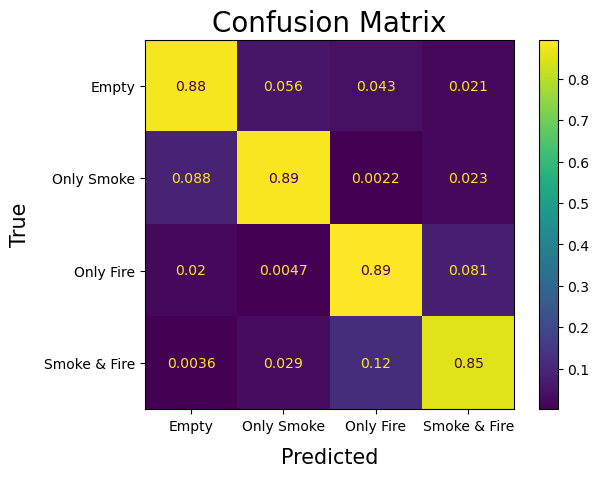

In [19]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_true=metrics['y_true'], 
                                        y_pred=metrics['y_hat'],
                                        normalize='true',
                                        display_labels=['Empty', 'Only Smoke', 'Only Fire', 'Smoke & Fire'],
                                        cmap='viridis',
                                        ax=ax)
plt.title("Confusion Matrix", fontsize=20)
ax.set_xlabel("Predicted", fontsize=15, labelpad=10)
ax.set_ylabel("True", fontsize=15,labelpad=10)
#plt.style.use("seaborn-v0_8")
plt.show()

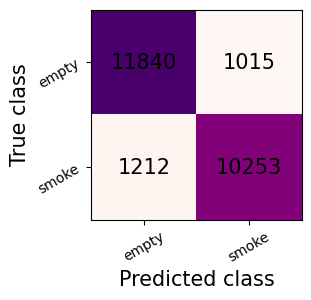

In [20]:
fig, ax = smoke_conf_mtx_metric.plot(cmap='RdPu')
fig.set_size_inches(3,3)
ax.set_xticks(range(2), ['empty', 'smoke'], rotation=30)
ax.set_yticks(range(2), ['empty', 'smoke'], rotation=30)

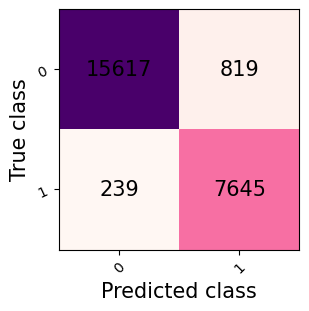

In [21]:
fig, ax = fire_conf_mtx_metric.plot(cmap='RdPu')
fig.set_size_inches(3,3)

# Confusion Matrix with Seaborn

In [22]:
conf_mtx = confusion_matrix(y_true=metrics['y_true'], 
                            y_pred=metrics['y_hat'],
                            normalize='true')
print(type(conf_mtx))
cf_mtx_dic = {
    'Empty': conf_mtx[: , 0],
    'Only Smoke': conf_mtx[:, 1],
    'Only Fire': conf_mtx[:, 2],
    'Smoke & Fire': conf_mtx[:, 3]
}
print(conf_mtx)

<class 'numpy.ndarray'>
[[0.88005327 0.05612099 0.04251879 0.02130695]
 [0.08846868 0.88654398 0.00219483 0.0227925 ]
 [0.0204953  0.00469684 0.89368061 0.08112724]
 [0.00360881 0.02887044 0.11818838 0.84933237]]


In [23]:
pd_cf_mtx = pd.DataFrame(cf_mtx_dic, index=['Empty', 'Only Smoke', 'Only Fire', 'Smoke & Fire'])

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'Empty'),
  Text(0, 1.5, 'Only Smoke'),
  Text(0, 2.5, 'Only Fire'),
  Text(0, 3.5, 'Smoke & Fire')])

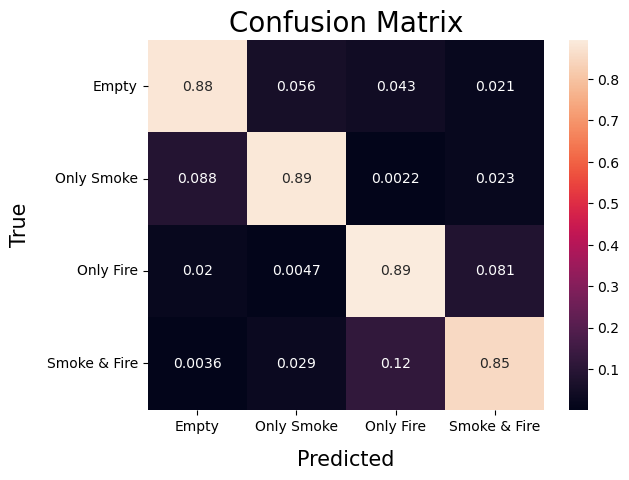

In [26]:
ax = sns.heatmap(pd_cf_mtx, annot=True)
ax.set_title("Confusion Matrix", fontsize=20)
ax.set_xlabel("Predicted", fontsize=15, labelpad=12)
ax.set_ylabel("True", fontsize=15,labelpad=12)
plt.yticks(rotation=0)

In [25]:
metrics_dic = {
    'accuracy': np.round(metrics['accuracy'].cpu().numpy().tolist(), 4),
    'precision': np.round(metrics['precision'].cpu().numpy().tolist(), 4),
    'recall': np.round(metrics['recall'].cpu().numpy().tolist(), 4),
    'f1': np.round(metrics['f1'].cpu().numpy().tolist(), 4)
}
metrics_df = pd.DataFrame(metrics_dic, index=['Smoke', 'Fire'])
metrics_df

,accuracy,precision,recall,f1
Smoke,0.9084,0.9099,0.8943,0.9020
Fire,0.9565,0.9032,0.9697,0.9353
